In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import tensorflow as tf

In [4]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter

# Define your model
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=3,  # Update to 3 output channels
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# Define dataset and data loaders for both training and validation sets
train_data_dir = "./images/TrainFullLabels30"
val_data_dir = "./images/ValFullLabels70"

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

train_dataset = MyDataset(train_data_dir, transform)
val_dataset = MyDataset(val_data_dir, transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

# Define a custom callback to plot both training and validation losses
class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()  # Move tensor to CPU and get its value
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()  # Move tensor to CPU and get its value
        with self.writer.as_default():
            tf.summary.scalar('Loss_', train_loss, step=epoch)
            tf.summary.scalar('Loss_', val_loss, step=epoch)


# Define Lightning trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[PlotLossCallback("./logs/")],
    profiler='simple'
)

# Initialize model and start training
model = AutoEncoder()
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | unet          | UNet             | 4.8 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.230    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 8/8 [00:46<00:00,  0.17it/s, v_num=56, val_loss=0.101]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 8/8 [00:47<00:00,  0.17it/s, v_num=56, val_loss=0.101]

FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  6738           

IndexError: tuple index out of range

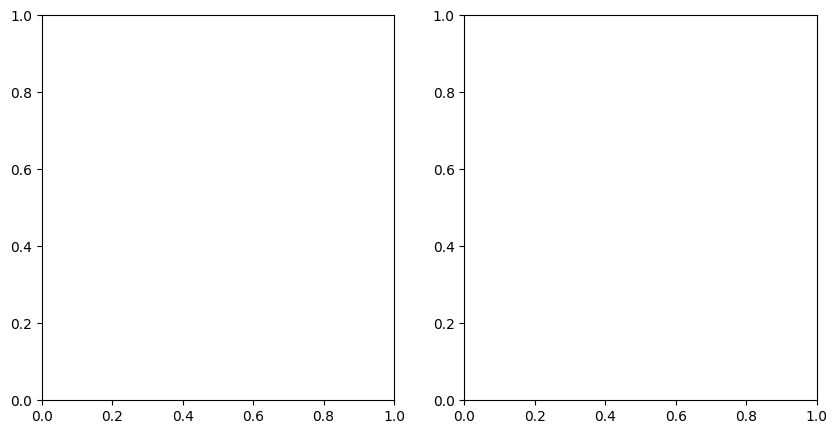

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

rdata = MyDataset(train_data_dir, transform)

# Pass the original data through the model to get reconstructed images
reconstructed_images = []
original_images = []
for data, _ in rdata:
    with torch.no_grad():
        # Ensure the data has the same shape as the expected input (batch size of 1)
        data = data.unsqueeze(0)
        reconstructed = model(data)
    reconstructed_images.append(reconstructed.squeeze().cpu().numpy())  # Remove batch dimension
    original_images.append(data.squeeze().cpu().numpy())  # Remove batch dimension

# Visualize original and reconstructed images
num_samples = len(reconstructed_images)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axes[0].imshow(original_images[i][0, :, :, original_images[i].shape[3]//2], cmap='gray')  
    axes[0].set_title('Original Training Image')
    axes[0].axis('off')
    
    # Reconstructed Image with Binary Threshold
    reconstructed_argmax = np.argmax(reconstructed_images[i], axis=0)
    reconstructed_binary = np.where(reconstructed_argmax == 0, 0, 1)
    axes[1].imshow(reconstructed_binary[:, :, reconstructed_images[i].shape[2]//2], cmap='gray') 
    axes[1].set_title('Reconstructed Training Image (Argmax)')
    axes[1].axis('off')
    
    plt.show()


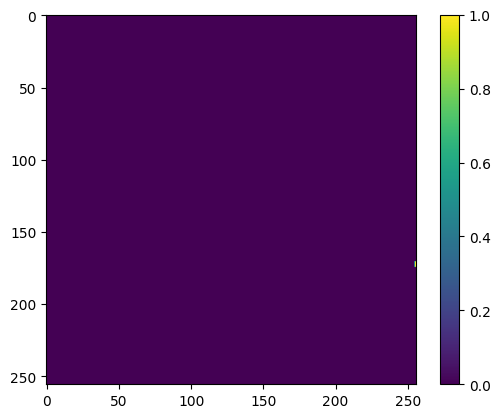

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example 2D image data
# Display the image with a colorbar
plt.imshow(np.argmax(reconstructed_images[i][0, :, :, :, 256//2], axis=0), cmap='viridis')
plt.colorbar()
plt.show()

In [9]:
np.max(reconstructed_images[0][0, 1, :, :, 256//2])

1.0524333

In [10]:
len(dataloader)

4

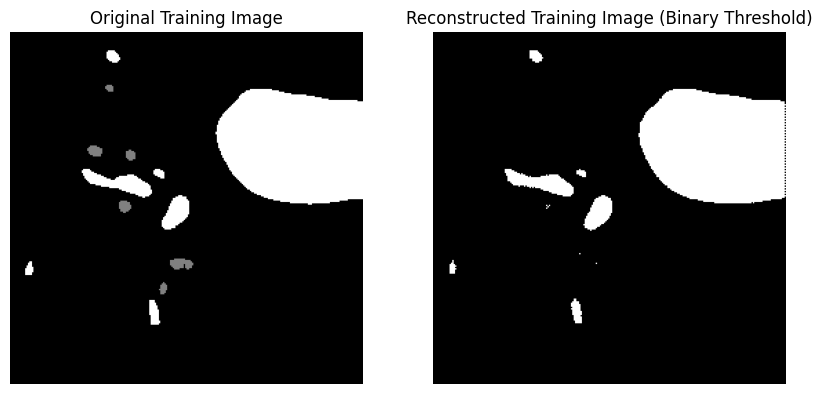

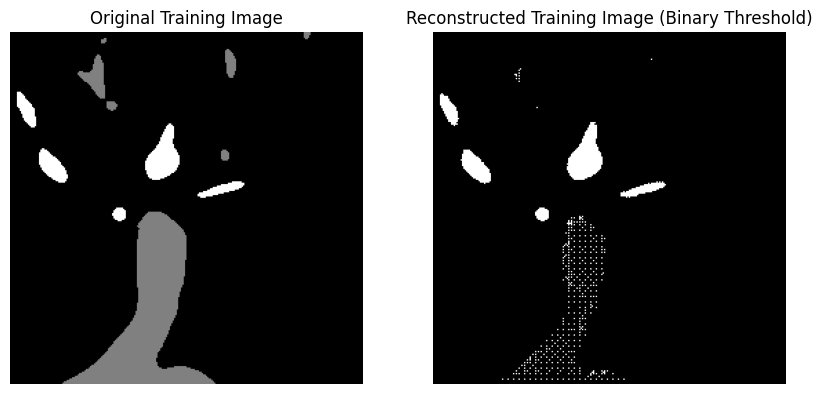

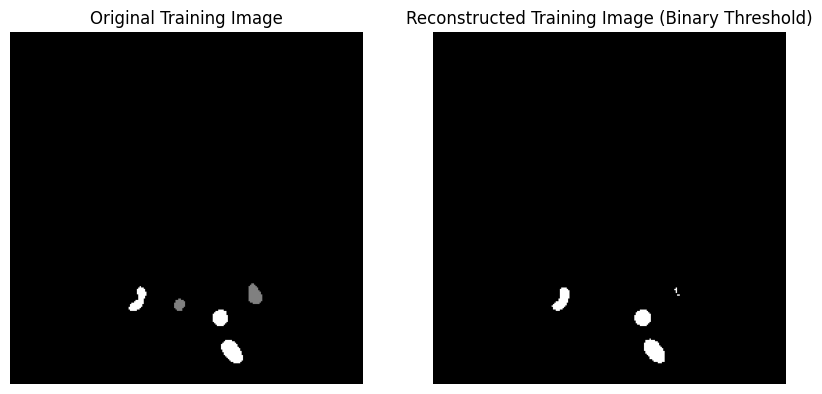

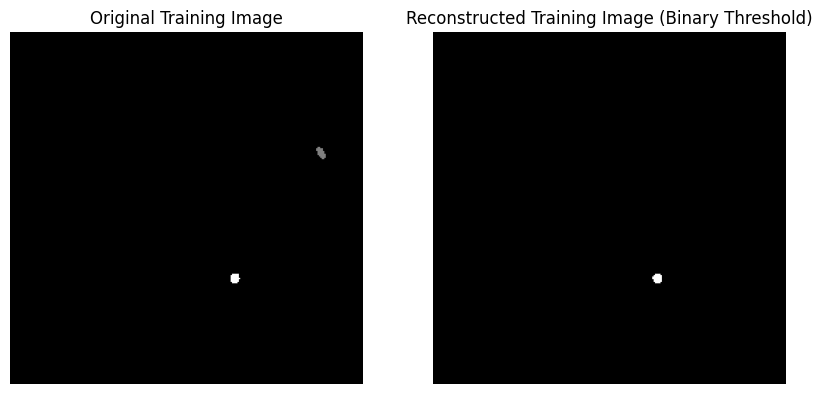

In [13]:
#PASSING NEW IMAGE THROUGH 
import matplotlib.pyplot as plt
import numpy as np

data_dir = data_dir = "./images/TempLabels"
dataset_ = MyDataset(data_dir, transform)
dataloader_ = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
# Set the model to evaluation mode
model.eval()

# Pass the original data through the model to get reconstructed images
reconstructed_images = []
original_images = []
for data, _ in dataloader:
    with torch.no_grad():
        reconstructed = model(data)
    reconstructed_images.append(reconstructed.cpu().numpy())
    original_images.append(data.cpu().numpy())

# Visualize original and reconstructed images
num_samples = len(reconstructed_images)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axes[0].imshow(original_images[i][0, 0, :, :, 256//2], cmap='gray')  
    axes[0].set_title('Original Training Image')
    axes[0].axis('off')
    
    # Reconstructed Image with Binary Threshold
    reconstructed_norm = reconstructed_images[i][0, 0, :, :, 256//2] / np.max(reconstructed_images[i][0, 0, :, :, 256//2])  # Normalize to [0, 1]
    reconstructed_binary = np.where(reconstructed_norm > 0.5, 1, 0)
    axes[1].imshow(reconstructed_binary, cmap='gray') 
    axes[1].set_title('Reconstructed Training Image (Binary Threshold)')
    axes[1].axis('off')
    
    plt.show()